# Generate sample dataset

In [1]:
import numpy as np
import random as rd
import math
import pandas as pd
from numpy import log2 as log
import pprint
eps = np.finfo(float).eps

In [20]:
class datagen:
    def __init__(self, m):
#         self.k = k # number of features
        self.m = m # number of data points
        self.arrofarrX = []
        self.arrY = []
        
        for i in range(self.m):
            tmpX = self.generateX()
            tmpY = self.computeY(tmpX)
            self.arrofarrX.append(tmpX)
            self.arrY.append(tmpY)
            
        self.df = pd.DataFrame(self.arrofarrX)
        L = len(self.arrofarrX[0])
        self.df['Y'] = self.arrY
        
    def ran(self,x,y):
        if rd.uniform(x,y) > 0.5:
            return 1
        else:
            return 0
    
    def ran2(self,x,y):
        if rd.uniform(x,y) > 0.25:
            return 1
        else:
            return 0
        
    def generateX(self):
        new = []
        if self.ran(0,1) == 1:
            new.append(1)
        else:
            new.append(0)
        
        for x in range(1,14):
            if self.ran2(0,1) == 1:
                new.append(new[x-1])
            else:
                new.append(1-new[x-1])
        for x in range(15,21):
            if self.ran(0,1) == 1:
                new.append(0)
            else:
                new.append(1)
        return new
    
    def computeY(self,arrX):
        res = 0
        count0 = 0
        count1 = 0
        if arrX[0] == 0:
            for x in range(1,8):
                if arrX[x] == 0:
                    count0+=1
                else:
                    count1+=1
        else:
            for x in range(8,15):
                if arrX[x] == 0:
                    count0+=1
                else:
                    count1+=1
        
        if count0 > count1:
            return 0
        else:
            return 1

# Building Decision Tree

# Compute $H(Y)$

In [3]:
def find_entropy(df):
    ClFI = df.keys()[-1]   # to get the attribute name of classifcation column
    entropy = 0
    values = df[ClFI].unique()
    for value in values:
        fraction = df[ClFI].value_counts()[value]/len(df[ClFI])
        entropy += -fraction*np.log2(fraction)
    return entropy

# Compute $H(Y|X) = \sum_{x}P(X = x)[-\sum_{y}P(Y=y|X=x)\log P(Y=y|X=x)]$

In [4]:
def find_entropy_attribute(df,attribute):
    ClFI = df.keys()[-1]      
    target_variables = df[ClFI].unique()  
    variables = df[attribute].unique()    
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[ClFI] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        fraction2 = den/len(df)
        entropy2 += -fraction2*entropy
    return abs(entropy2)

# Find the attribute that could lead to biggest entropy

In [5]:
def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
#         Entropy_att.append(find_entropy_attribute(df,key))
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]

# get subtable since we find a attribute to cut the table

In [6]:
def get_subtable(df, node,value):
    return df[df[node] == value].reset_index(drop=True)

# (DFS IMPLEMENTATION)FINAL STEP: LETS BUILD DECISION TREE

In [7]:
def buildTree(df,tree=None): 
    Class = df.keys()[-1]   
    
    node = find_winner(df)   #get the attribute that could lead to he biggest entropy
    
    attValue = np.unique(df[node])   #get the distint attribute in the colomen which lead to the
                                     #biggest entrophy
    
    #init a dictonary structure to store the entire decision tree
    # which is a dictionary of dictionary
    # the innder dictionary used to store the current layer of decision tree
    if tree is None:                    
        tree={}
        tree[node] = {}
    
    #find the index of last column
    
    for value in attValue:
        
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable['Y'],return_counts=True)    #based on the subtable, if counts of unique array
                                                                        #equals one, means only one case exist to decide Y
        if len(counts)==1:
            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = buildTree(subtable) #DFS 
                   
    return tree

# Prediction function: input 1 is the decision tree, input 2 is the dataset that need to be predicted

In [8]:
def predict(pred_arr,tree):     #predict function is just to traverse the TREE using DFS 
    #DFS
    for node in tree.keys():
        value = pred_arr[node]
        tree = tree[node][value]
        ans = 0
        if type(tree) is dict:  # yet to reach the node
            ans = predict(pred_arr,tree)
        else:
            ans = tree
            break;
    return ans

# Compute the training error

In [9]:
def err_train(df,tree):
    count = 0
    l = len(df)
    for x in range(l):
        inst = df.iloc[x]
        ans = predict(inst,tree)
        if ans == inst[-1]:
            count+=1
        inst = 0
    return (l-count)/l

#  

# Quesiton (1), consider $m$ ranges from 10 to 10000, each time we use 80% dataset to train decision tree, and 20% dataset to predict

In [ ]:
err_history = []
count = 0
x_axis = []
for m in range(10,100):
    d = datagen(m)
    df = d.df
    trainset, predictset = np.split(df, [int(.8*len(df))])   #80% training set, 20% predicting set
    predictset.index = range(len(predictset.index))          #reindex the index of predicting set from zero to len-1
    tree = buildTree(trainset)                               #build decision tree using training set
#     errtrain = err_train2(trainset,tree)
    errpred = err_train(predictset,tree)
    err_history.append(errpred)
    x_axis.append(count)
    count = count + 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_axis, err_history)

# Question(2) 

# Count number of irrelevent variables function in tree

In [1164]:
def countirr(tree):
    #level order traverse tree
    if tree is None:
        return
    #create queue for level order trasversal
    
    ans = []
    queue = []
    key = list(tree.keys())
    p = [key[0],tree]
    queue.append(p)
#     ans.append(key[0])
    while(len(queue)>0):
        pair = queue.pop(0)
        node = pair[0]
        tree = pair[1]
        ans.append(node)
        tree0 = tree[node][0]
        tree1 = tree[node][1]
        if type(tree0) is dict:
            key = list(tree0.keys())
            pair = [key[0],tree0]
            queue.append(pair)
            
        if type(tree1) is dict:
            key = list(tree1.keys())
            pair = [key[0],tree1]
            queue.append(pair)
            
    ans = list(set(ans))  # get unique node number
    return ans

In [555]:
def height(tree):
    if type(tree) is not dict:
        return 0
    else:
        for node in tree.keys():
            treeleft = tree[node][0]
            lheight = height(treeleft)
            treeright = tree[node][1]
            rheight = height(treeright)
        
        if lheight > rheight :
            return lheight + 1
        else:
            return rheight + 1
        

In [12]:
def countirrela(arr):
    count= 0
    for i in range(len(arr)):
        if arr[i]>=15 and arr[i]<=20:
            count+=1
    return count

In [ ]:
err_history = []
irre_history = []
m = 0
x_axis = []
for m in range(10,100):
    value = 0.0
    errvalue = 0.0
    for i in range(10):
        d = datagen(m)
        df = d.df
        trainset, predictset = np.split(df, [int(.8*len(df))])
        predictset.index = range(len(predictset.index))         
        tree = buildTree(trainset)
        errpred = err_train(predictset,tree)
        errvalue+=errpred
        arrofirreindex = countirr(tree)
        irre_count = countirrela(arrofirreindex)
        value+=irre_count
    average = value/10
    ave_errvalue = errvalue/10
    err_history.append(ave_errvalue)
    x_axis.append(m)
    irre_history.append(average)
    print(m)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_axis, irre_history)

# Question(3)

# 3.1 Prunning by Depth:

In [773]:
def BFSprune(df):
    node = find_winner(df)  #root node
    attValue = np.unique(df[node]) #get unique attribute of 'Y' class
    tree = {}
    tree[node] = {}
    q = []
    #push node of root into queue
    for value in attValue:
            subtable = get_subtable(df,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if len(counts) == 1:
                tree[node][value] = clValue[0]
            else:
                childtree = {}
                tree[node][value] = childtree
                pair = [childtree,subtable]
                q.insert(0,pair)
    #BFS
    while(len(q)>0):
        element = q.pop()
        tmptree = element[0]
        tmpsubtable = element[1]
        
        node = find_winner(tmpsubtable)
        tmptree[node] = {}
        
        for value in attValue:
            subtable = get_subtable(tmpsubtable,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if len(counts) == 1:
                tmptree[node][value] = clValue[0]
            else:
                #enqueue
                childtree = {}
                tmptree[node][value] = childtree
                pair = [childtree,subtable]
                q.insert(0,pair)
    
    return tree


In [1249]:
def relativeheight(arr):
    ans = []
    last = len(arr)
    rootheight = arr[last-1]
    for i in reversed(arr):
        ans.append(rootheight - i)
    return ans

def computeheight_eachnode(tree):
    heightarr = []
    #BFS to traverse tree and stroe height for each node
    queue = []
    key = list(tree.keys())
    p = [key[0],tree]
    queue.append(p)
#     heightarr.append(height(tree))
    heightarr.insert(0,height(tree))
    while(len(queue)>0):
        pair = queue.pop(0)
        node = pair[0]
        tree = pair[1]
        tree0 = tree[node][0]
        tree1 = tree[node][1]
        if type(tree0) is dict:
            key = list(tree0.keys())
            pair = [key[0],tree0]
#             heightarr.append(height(tree0))
            heightarr.insert(0,height(tree0))
            queue.append(pair)
        if type(tree1) is dict:
            key = list(tree1.keys())
            pair= [key[0],tree1]
            queue.append(pair)
#             heightarr.append(height(tree1))
            heightarr.insert(0,height(tree1))
    
    ans = relativeheight(heightarr)
    return ans


In [775]:
def coinflip(num0,num1):
    if num0 == num1:
        if ran()==0:
            return 0
        else:
            return 1
    elif num0 > num1:
        return 0
    else:
        return 1
    
def majority(df):
    #count 1
    num0 = 0
    num1 = 0
    #delete last col of df
    t = df.drop(labels = 'Y',axis=1)
    #number of row of df
    num_col = len(t)
    #loop every row
    for i in range(num_col):
        tmprow = t.iloc[[i]]
        arr = tmprow.as_matrix()[0]
        for x in range(len(arr)):
            if arr[x] == 0:
                num0+=1
            else:
                num1+=1
    ans = coinflip(num0,num1)
    return ans

In [776]:
def ran():
        if rd.uniform(0,1) > 0.5:
            return 1
        else:
            return 0

In [1160]:
def BFSnodearray(tree):
    #level order traverse tree
    if tree is None:
        return
    #create queue for level order trasversal
    
    ans = []
    queue = []
    key = list(tree.keys())
    p = [key[0],tree]
    queue.append(p)
#     ans.append(key[0])
    while(len(queue)>0):
        pair = queue.pop(0)
        node = pair[0]
        tree = pair[1]
        ans.append(node)
        tree0 = tree[node][0]
        tree1 = tree[node][1]
        if type(tree0) is dict:
            key = list(tree0.keys())
            pair = [key[0],tree0]
            queue.append(pair)
            
        if type(tree1) is dict:
            key = list(tree1.keys())
            pair = [key[0],tree1]
            queue.append(pair)
        
    return ans

In [1430]:
def dephprune(df,heiarr,thresohold):
    node = find_winner(df)  #root node
    attValue = np.unique(df[node]) #get unique attribute of 'Y' class
    tree = {}
    tree[node] = {}
    q = []
    #push node of root into queue
    cur_height = heiarr.pop(0)
#     print("current node is ", node)
    
#     print("pop height",cur_height)
    for value in attValue:
            subtable = get_subtable(df,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if cur_height >= thresohold or  len(counts) == 1:
                tree[node][value] = clValue[0]
            else:
                childtree = {}
                tree[node][value] = childtree
                pair = [childtree,subtable]
                q.insert(0,pair)
    #BFS
    while(len(q)>0):
        element = q.pop()
        tmptree = element[0]
        tmpsubtable = element[1]
        
        node = find_winner(tmpsubtable)
        tmptree[node] = {}
        cur_height = heiarr.pop(0)
#         print("current node is ", node)
#         print("pop height",cur_height)
        for value in attValue:
            subtable = get_subtable(tmpsubtable,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if cur_height >= thresohold or len(counts) == 1:
                tmptree[node][value] = majority(subtable)
            else:
                #enqueue
                childtree = {}
                tmptree[node][value] = childtree
                pair = [childtree,subtable]
                q.insert(0,pair)
    
    return tree

In [ ]:
#1. get accurate height for each node
#2. first give each node a distinct number(BFS)
#3. reconstruct a tree with distinct node number 
#4. compute level number for each node    

In [1427]:
def distinctTree(df):
    node = find_winner(df)  #root node
    attValue = np.unique(df[node]) #get unique attribute of 'Y' class
#     print("current node is ", node)
    tree = {}
    tree[node] = {}
    q = []
    #########
    newtree = {}
    newtree[0] = {}
    newq = []
    nodecount = 0
    #########
    #push node of root into queue
    for value in attValue:
            subtable = get_subtable(df,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if len(counts) == 1:
                tree[node][value] = clValue[0]
                ###########
                newtree[nodecount][value] = clValue[0]
                ###########
            else:
                childtree = {}
                tree[node][value] = childtree
                pair = [childtree,subtable]
                q.insert(0,pair)
                ###########
                newchildtree = {}
                newtree[nodecount][value] = newchildtree
                newpair  = [newchildtree,0]
                newq.insert(0,newpair)
                ###########
    #BFS
    while(len(q)>0):
        element = q.pop()
        tmptree = element[0]
        tmpsubtable = element[1]
        
        node = find_winner(tmpsubtable)
        tmptree[node] = {}
#         print("current node is ", node)
        ##############
        nodecount+=1
        newelement = newq.pop()
        newtmptree = newelement[0]
#         newnode = 1
#         newnode += newelement[1]
        newtmptree[nodecount] = {}
        ##############
        
        for value in attValue:
            subtable = get_subtable(tmpsubtable,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if len(counts) == 1:
                tmptree[node][value] = clValue[0]
                ############
                newtmptree[nodecount][value] = clValue[0]
                ############
            else:
                #enqueue
                childtree = {}
                tmptree[node][value] = childtree
                pair = [childtree,subtable]
                q.insert(0,pair)
                ############
                newchildtree = {}
                newtmptree[nodecount][value] = newchildtree
                newpair = [newchildtree,nodecount]
                newq.insert(0,newpair)
                ############
    
    return tree,newtree



In [1402]:
def levelcompute(tree,length):
    #level order traverse tree
    if tree is None:
        return
    #create queue for level order trasversal
    
    ans = []
    queue = []
    key = list(tree.keys())
    p = [key[0],tree]
    queue.append(p)
#     ans.append(key[0])

    #-----compute level-----#
    visited = set()
    visited.add(key[0])
    levelarr = [0 for x in range(length)]
    levelarr[key[0]] = 0
    #-----------------------#
    while(len(queue)>0):
        pair = queue.pop(0)
        node = pair[0]
        tree = pair[1]
        ans.append(node)
        tree0 = tree[node][0]
        tree1 = tree[node][1]
    
        if type(tree0) is dict:
            key = list(tree0.keys())
            pair = [key[0],tree0]
            queue.append(pair)
            #-------compute level-----#
            if key[0] not in visited:
                levelarr[key[0]] = levelarr[node] + 1 
                visited.add(key[0])
            #-------------------------#
        if type(tree1) is dict:
            key = list(tree1.keys())
            pair = [key[0],tree1]
            queue.append(pair)  
            #-------compute level-----#
            if key[0] not in visited:
                levelarr[key[0]] = levelarr[node] + 1 
                visited.add(key[0])
            #-------------------------#
            
    return levelarr

In [1410]:
d = datagen(20)
df = d.df

In [1411]:
tree, distin= distinctTree(df)

current node is  4
current node is  0
current node is  0
current node is  5
current node is  10


In [1425]:
ans = BFSnodearray(distin)
print("node array is",ans,"len is ", len(ans))


heiarr = computeheight_eachnode(tree)#no need any more
print("heiarr array is",heiarr,"len is ", len(heiarr))

node array is [0, 1, 2, 3, 4] len is  5
heiarr array is [0, 1, 1, 2, 2] len is  5


In [1423]:
ans = BFSnodearray(distin)
l = len(ans)
hei = levelcompute(distin,l)

In [1420]:
newtree = dephprune(df,hei,1)

current node is  4
pop height 0
current node is  0
pop height 1
current node is  0
pop height 1


In [1432]:
#plot graph comparing test set and depth d,10000 dataset, 8000 for training
err_pred_history = []
err_test_history = []
x_axis = []
count = 0
for depth in range(1,10):
    overalltest = 0.0
    overallpred = 0.0
    for i in range(10):
        d = datagen(100)
        df = d.df
        trainset,predictset = np.split(df,[int(.8*len(df))])
        predictset.index = range(len(predictset.index))
        tree, distin= distinctTree(df)
        ans = BFSnodearray(distin)
        l = len(ans)
        heightarr = levelcompute(distin,l)
        newtree = dephprune(df,heightarr,depth)
        errortest = err_train(trainset,newtree)
        errpred = err_train(predictset,newtree)
        overalltest+=errortest
        overallpred+=errpred
        print("current loopnumber is ",count)
        count+=1
    ave_test = overalltest/10
    ave_pred = overallpred/10
    err_pred_history.append(ave_pred)
    err_test_history.append(ave_test)
    x_axis.append(depth)
    print(depth)
        


current loopnumber is  0
current loopnumber is  1
current loopnumber is  2
current loopnumber is  3
current loopnumber is  4
current loopnumber is  5
current loopnumber is  6
current loopnumber is  7
current loopnumber is  8
current loopnumber is  9
1
current loopnumber is  10
current loopnumber is  11
current loopnumber is  12
current loopnumber is  13
current loopnumber is  14
current loopnumber is  15
current loopnumber is  16
current loopnumber is  17
current loopnumber is  18
current loopnumber is  19
2
current loopnumber is  20
current loopnumber is  21
current loopnumber is  22
current loopnumber is  23
current loopnumber is  24
current loopnumber is  25
current loopnumber is  26
current loopnumber is  27
current loopnumber is  28
current loopnumber is  29
3
current loopnumber is  30
current loopnumber is  31
current loopnumber is  32
current loopnumber is  33
current loopnumber is  34
current loopnumber is  35
current loopnumber is  36
current loopnumber is  37
current loopnumb

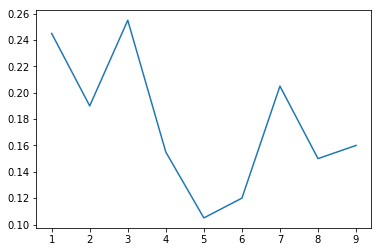

In [1438]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_axis, err_pred_history)

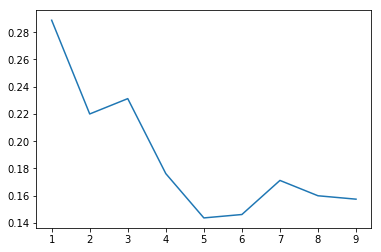

In [1437]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(x_axis, err_test_history)

## 3(b)

In [1089]:
d = datagen(40)
df = d.df

In [1099]:
def sample_size_subBFSprune(df):
    subhistory = []
    subhistory.insert(0,df)
    node = find_winner(df)  #root node
    attValue = np.unique(df[node]) #get unique attribute of 'Y' class
    tree = {}
    tree[node] = {}
    q = []
    #push node of root into queue
    for value in attValue:
            subtable = get_subtable(df,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if len(counts) == 1:
                tree[node][value] = clValue[0]
            else:
                childtree = {}
                tree[node][value] = childtree
                pair = [childtree,subtable]
                subhistory.insert(0,subtable)
                q.insert(0,pair)
    #BFS
    while(len(q)>0):
        element = q.pop()
        tmptree = element[0]
        tmpsubtable = element[1]
        
        node = find_winner(tmpsubtable)
        tmptree[node] = {}
        
        for value in attValue:
            subtable = get_subtable(tmpsubtable,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if len(subtable) < 10 or len(counts)==1:
                tmptree[node][value] = majority(subtable)
            else:
                #enqueue
                childtree = {}
                tmptree[node][value] = childtree
                pair = [childtree,subtable]
                subhistory.insert(0,subtable)
                q.insert(0,pair)
    
    return tree,subhistory

In [1100]:
tree, subhistory = sample_size_subBFSprune(df)

In [1101]:
tree

{7: {0: {17: {0: 0, 1: {13: {0: 0, 1: 1}}}},
  1: {13: {0: {10: {0: 0, 1: 1}}, 1: {0: {0: 1, 1: 1}}}}}}

# 3(c) Prunning by Significance
1. find the node lead to biggest $IG$
2. Compute $X^{2}-test$ for that node

In [1033]:
def getnumof01(arr):
    count0 = 0
    count1 = 0
    for i in range(len(arr)):
        if arr[i] == 0:
            count0+=1
        else:
            count1+=1
    return count0,count1

def computeobservation(node_arr,y_arr):
    count00,count01,count10,count11 = 0,0,0,0
    row = len(node_arr)
    for i in range(row):
        if node_arr[i] == 0 and y_arr[i] == 0:
            count00+= 1
        elif node_arr[i] == 0 and y_arr[i] == 1:
            count01+=1
        elif node_arr[i] == 1 and y_arr[i] == 0:
            count10+=1
        elif node_arr[i] == 1 and y_arr[i] == 1:
            count11+=1
    return count00,count01,count10,count11
    
def chitest(node,table):
    chisquare = 0.0
    N = len(df.index)
    #compute p of node
    node_col = df[node]
    node_arr = node_col.as_matrix()
    node_count0,node_count1 = getnumof01(node_arr)
    px1 = node_count1/(node_count0+node_count1)
    px0 = 1- px1
    #compute p of Y col
    y_col = df['Y']
    y_arr = y_col.as_matrix()
    y_count0,y_count1 = getnumof01(y_arr)
    py1 = y_count1 /(y_count1 + y_count0)
    py0 = 1- py1
    #compute chi square err
    count00,count01,count10,count11 = computeobservation(node_arr,y_arr)
    # x = 0, y  = 0
    chisquare +=((px0*py0)*N-count00)**2/((px0*py0)*N) 
    # x = 0, y = 1
    chisquare += ((px0*py1)*N-count01)**2/((px0*py1)*N)
    # x = 1, y = 0
    chisquare += ((px1*py0)*N - count10)**2/((px1*py0)*N)
    # x = 1, y = 1
    chisquare += ((px1*py1)*N- count11)**2/((px1*py1)*N)
    
    return chisquare

In [1043]:
d = datagen(20)
df = d.df
node = find_winner(df)
node

9

In [1123]:
def chisquare_subBFSprune(df):
    subhistory = []
    subhistory.insert(0,df)
    node = find_winner(df)  #root node
    attValue = np.unique(df[node]) #get unique attribute of 'Y' class
    tree = {}
    tree[node] = {}
    q = []
    #push node of root into queue
    for value in attValue:
            subtable = get_subtable(df,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if len(counts) == 1:
                tree[node][value] = clValue[0]
            else:
                childtree = {}
                tree[node][value] = childtree
                pair = [childtree,subtable]
                subhistory.insert(0,subtable)
                q.insert(0,pair)
    #BFS
    while(len(q)>0):
        element = q.pop()
        tmptree = element[0]
        tmpsubtable = element[1]
        
        node = find_winner(tmpsubtable)
        tmptree[node] = {}
        
        for value in attValue:
            subtable = get_subtable(tmpsubtable,node,value)
            clValue,counts = np.unique(subtable['Y'],return_counts=True)
            
            if  chitest(node,tmpsubtable) <3.841 or len(counts)==1:
                tmptree[node][value] = majority(subtable)
            else:
                #enqueue
                childtree = {}
                tmptree[node][value] = childtree
                pair = [childtree,subtable]
                subhistory.insert(0,subtable)
                q.insert(0,pair)
    
    return tree,subhistory

In [1124]:
tree,subhistory = chisquare_subBFSprune(df)

In [1125]:
tree

{7: {0: {17: {0: 0, 1: 0}}, 1: {13: {0: 1, 1: 1}}}}